In [5]:
import numpy as np
from obspy import read
from obspy.io.xseed import Parser
from obspy.imaging.spectrogram import _nearest_pow_2
from scipy import signal
import obspy
import matplotlib.pyplot as plt
from IPython.display import Image

from matplotlib import mlab, transforms
plt.rcParams['image.cmap'] = 'inferno'
import math as M
import matplotlib as mpl
import numpy.ma as ma
import time as time
import os
import gc

from func.def_master import hps_algo
from func.def_plot import plot_data

## Set Parameter for Station, Date, Filters

In [6]:
station = 'KNR01' ## Station
#components = ['BHZ']

depas = True

if depas == True:
    components = ['BHZ', 'BH1', 'BH2']## Component
    data_decimate_factor = 2
    
else:
    components = ['HHZ', 'HH1', 'HH2']## Component
    data_decimate_factor = 4
    
#components = ['BHZ', 'BH1', 'BH2', 'BDH']## Component
#components = ['BHZ']
year = 2016
#day = '065'
startday = '343'
year= str(year)

#pre_filt=(.001,.005,12,15) ## Parameter for filtering during response remove
pre_filt=(.005,.006,10,12) ## Parameter for filtering during response remove
#data_decimate_factor = 2
freq_min_bandpass = .9 ## filtercorners for filtering after response remove
freq_max_bandpass = 10 ## filtercorners for filtering after response remove
#per_lap = .9
path_npy_files = '/home/david/AWI/Results/'+year+'/'
path_plots = path_npy_files

if os.path.isdir(path_npy_files+station) == False:
    if os.path.isdir(path_npy_files) == False:
        os.mkdir(path_npy_files)
    os.mkdir(path_npy_files+station)

In [8]:
## original to calculate with gaps inbetween days
#start_day = str(day)

year = str(year)

number_of_days = 1

threshold = -11
threshold = 10**(threshold)

save_it=True
plot_it=True

add_time = 1 # hours to add before/after day in hour
#per_lap = .1




#freq_minimal_value = 3
#distance = 120
#maxima= 1
#decimate_factor = 1e-15


day = startday
for i in range(number_of_days):
    for j in range(len(components)):
        print(day)
        ## Depends on workstation 
        trace = read('/home/david/AWI/'+year+'/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + str(int(day)))
        trace += read('/home/david/AWI/'+year+'/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + str(int(day)+1))
        trace += read('/home/david/AWI/'+year+'/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + str(int(day)-1))

        
        
        # read in data for day before/after day of interest
        #trace = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + str(int(day)))
        #trace += read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + str(int(day)+1))
        #trace += read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + str(int(day)-1))
        trace.merge(method=1)
        #print(trace[0].stats)
        
        ## calculate values to trim
        time_win_to_use = trace[0].stats.starttime+24*3600
        trim_start = time_win_to_use - (add_time)*3600
        trim_end = time_win_to_use + (24+add_time)*3600 - trace[0].stats.delta
        #print(trim_start, trim_end)
        
        trace.trim(trim_start, trim_end)
        #print(trace[0].stats)
        
        
        resp_file = Parser('/home/david/AWI/KNIPAS_dataless/RESP.1B.' + station + '..' + components[j])
        #resp_file = ('/data/cen/u254/Essing/AWI/Dataless_SEEDS/RESP.1B.' + station + '..' + components[j])
        trace = trace.decimate(factor=data_decimate_factor)
        fs = int(trace[0].stats.sampling_rate)
        trace_simu = trace.copy()
        trace_simu.simulate(paz_remove=None, pre_filt=pre_filt, seedresp={'filename': resp_file, 'units': 'ACC'})
        trace_simu_filt = trace_simu.copy()
        trace_simu_filt = trace_simu_filt.filter('bandpass',freqmin=freq_min_bandpass, freqmax=freq_max_bandpass)
        trace_data = np.array(trace_simu_filt[0].data)
        trace_data -= trace_data.mean()

        
            
        
        #npts = len(trace_data)
        #wlen = 80 # in seconds
        #nfft = int(_nearest_pow_2(wlen * fs)) # number of datapoints used in each block for fft
        #nlap = int(nfft * float(per_lap))
        nfft = 2000
        pad_to = 2048
        
        # hanning window is set to default in mlab.specgram
        specgram, specgram_freq, specgram_time = mlab.specgram(trace_data, Fs=fs, NFFT=nfft, noverlap=0)
        #print(np.shape(specgram))
        #specgram_BHZ_masekd = ma.array(trace_data)
        #specgram_BHZ_masekd[0:1000,:] = ma.masked
        #specgram_BHZ_masekd[1300:np.shape(specgram_BHZ)[0],:] = ma.masked

        ### time arrangements
        
        if j==0:
            #specgram_appended_all_comps =  np.zeros((len(components), np.shape(specgram)[0], np.shape(specgram)[1]*number_of_days))
            first_date_1 = trace[0].stats.endtime.ctime()
            first_date = str(first_date_1[-4:]), '-', (first_date_1[4:7]), str(first_date_1[8:10])
            #all_days_amp_values = np.zeros((number_of_days, len(amplitude_values)))
            #all_days_freq_values = np.zeros((number_of_days, len(frequency_values)))
            time_stack = specgram_time
            
            
            fund_freq_value = np.zeros((len(components), np.shape(specgram)[1]))
            fund_freq_value_all =  np.zeros_like(fund_freq_value)
            fund_freq_indi = np.zeros_like(fund_freq_value)
            fund_freq_amplitude =  np.zeros_like(fund_freq_value)
            fund_freq_amplitude_all = np.zeros_like(fund_freq_value)
            trace_time_domain = np.zeros((len(components), len(trace_data)))
            #fund_freq_amplitude_all_muted = np.zeros_like(fund_freq_value_appended)
        
        
        #if i!=0 and j==0:
        #    time_stack = np.append(time_stack, time_stack[-1]+specgram_time)        
        
        
        
        #if i==0:      
        #    specgram_appended = specgram        
        #if i!=0:
        #    specgram_appended = np.append(specgram_appended, specgram, axis=1)
            
        if j==0:
            specgram_all_comps = np.zeros((len(components), np.shape(specgram)[0], np.shape(specgram)[1]))
            #specgram_appended = 0
            #print('I was here')
        specgram_all_comps[j,:,:] = specgram
            
        
        #print(np.shape(specgram_appended))
        
        #print(np.shape(fund_freq_value_appended), np.shape(fund_freq_indi_appended), np.shape(fund_freq_amplitude_appended))
    
    

    
    
        fund_freq_amplitude_all[j,:], fund_freq_amplitude[j,:], fund_freq_value_all[j,:], fund_freq_value[j,:], fund_freq_indi[j,:] = hps_algo(input_data=specgram, freq_range_input_data=specgram_freq, min_freq=-1, max_freq=0.000001, nr_downsamp=4, amp_threshold=threshold)
        trace_time_domain[j,:] = trace_data
    
    fund_freq_amplitude_all = fund_freq_amplitude_all[:,45:1125]
    fund_freq_amplitude = fund_freq_amplitude[:,45:1125]
    #fund_freq_amplitude_all_muted = fund_freq_amplitude_all_muted[:,45:1125]
    fund_freq_indi = fund_freq_indi[:,45:1125]
    fund_freq_value = fund_freq_value[:,45:1125]
    fund_freq_value_all = fund_freq_value_all[:,45:1125]

    specgram_all_comps = specgram_all_comps[:,:,45:1125]
    
    trace_data_one_day = trace_time_domain[:,3600*fs:len(trace_data)-3600*fs]
    trace_data_one_day_time_line = np.linspace(0,24,np.shape(trace_data_one_day)[1])

    
    if save_it == True:
        np.save(file=(path_npy_files+'/'+station+'/1B.'+station+'.'+str(year)+'.'+day+'_amp_values'), arr=fund_freq_amplitude_all)
        np.save(file=(path_npy_files+'/'+station+'/1B.'+station+'.'+str(year)+'.'+day+'_freq_values'), arr=fund_freq_value_all)
        np.save(file=(path_npy_files+'/'+station+'/1B.'+station+'.'+str(year)+'.'+day+'_specgrams'), arr=specgram_all_comps)
        np.save(file=(path_npy_files+'/'+station+'/1B.'+station+'.'+str(year)+'.'+day+'_trace'), arr=trace_data_one_day)
        #fund_freq_amplitude_all_appended[j,:],  fund_freq_amplitude_appended[j,:],fund_freq_amplitude_all_muted_appended[j,:], fund_freq_indi_appended[j,:],  fund_freq_value_appended[j,:],  fund_freq_value_all_appended[j,:] = hps_algo(input_data=specgram_appended, freq_range_input_data=specgram_freq, min_freq=-1, max_freq=0.0001, nr_downsamp=4,number_of_days=number_of_days, amp_threshold=threshold)
        #fund_freq_value_appended[j,:], fund_freq_indi_append ed[j,:], fund_freq_amplitude_appended[j,:]  = hps_algo(input_data=specgram_appended, freq_range_input_data=freq, min_freq=-1, max_freq=0.0001, nr_downsamp=4, amp_threshold=threshold)

    middle_day_specgram_time = specgram_time[45:1125]-3600
    
    if plot_it ==  True:
        plot_data(components=components, trace=trace_data_one_day, trace_time_vector=trace_data_one_day_time_line,  specgram_time_vector=middle_day_specgram_time, specgram_freq_vector=specgram_freq,  specgram=specgram_all_comps, freq_values=fund_freq_value_all, amplitude_values=fund_freq_amplitude_all, path=path_plots, station=station, year=year,day=day)
    plt.close('all')
    gc.collect()
    day = int(day) + 1
    day = (("%03d" % day)) 
    ### Get amplitude at points in specgram without downsampling
    
    
   
if save_it==True:
    np.save(file=(path_npy_files+'/'+station+'/1B.'+station+'._time'), arr=middle_day_specgram_time)    
    np.save(file=(path_npy_files+'/'+station+'/1B.'+station+'._freq'), arr=specgram_freq)    
    np.save(file=(path_npy_files+'/'+station+'/1B.'+station+'._trace_time_line'), arr=trace_data_one_day_time_line)
   


343


/home/david/anaconda3/envs/vgseis_2018/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


343
343


FileNotFoundError: [Errno 2] No such file or directory: '/home/david/AWI/Results/2017//KNR01/1B.KNR01.2016.343_amp_values.npy'

In [ ]:
fund_freq_value*2

NameError: name 'trace_time_vector' is not defined

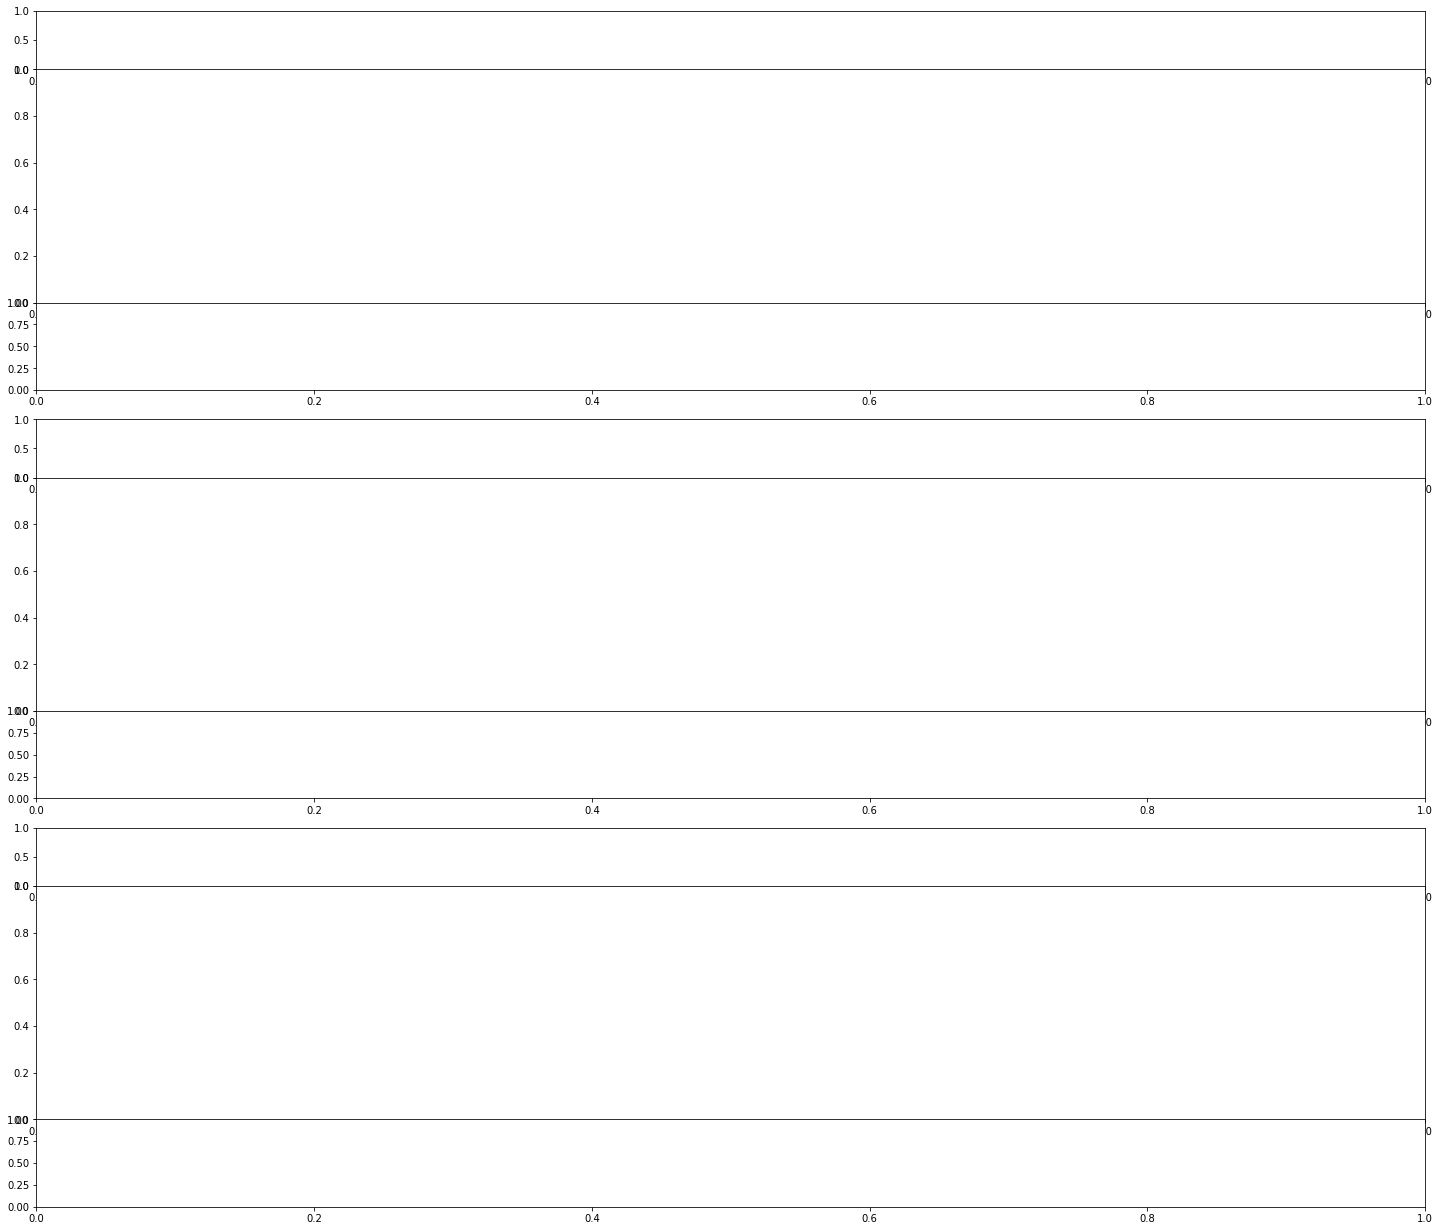

In [9]:
#while i < np.shape(specgram)[0]:
gridsize = (41, 9)
fig = plt.figure(figsize=(32, 22))
fig.subplots_adjust(hspace=0, wspace=0)
    #fig.suptitle(station + '.' + 'starttime: ' +  first_date)
    #fig.suptitle(station + '.' + component + '_' + 'starttime: ' +  str(trace[0].stats.starttime)[0:19])

    ## BHZ
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=7, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=7, rowspan=8, sharex=ax1)
ax3 = plt.subplot2grid(gridsize, (10, 0), colspan=7, rowspan=3, sharex=ax1)


## BH1

ax4 = plt.subplot2grid(gridsize, (14, 0), colspan=7, rowspan=2, sharey=ax1)
ax5 = plt.subplot2grid(gridsize, (16, 0), colspan=7, rowspan=8, sharex=ax1)
ax6 = plt.subplot2grid(gridsize, (24, 0), colspan=7, rowspan=3, sharex=ax1, sharey=ax3)

## BH2

ax7 = plt.subplot2grid(gridsize, (28, 0), colspan=7, rowspan=2, sharey=ax1)
ax8 = plt.subplot2grid(gridsize, (30, 0), colspan=7, rowspan=8, sharex=ax1)
ax9 = plt.subplot2grid(gridsize, (38, 0), colspan=7, rowspan=3, sharex=ax1, sharey=ax3)





ax1.plot(trace_time_vector,trace[0,:], color='maroon')
ax1.set_xlim(0,24)
ax1.title.set_text(components[0])
ax1.set_ylim(-.005,.005)
ax1.set_ylabel('Acceleration')
ax1.set_xticks([])


ax2.pcolormesh(specgram_time_vector/3600, specgram_freq_vector, 10*np.log10(specgram[0,:,:]))
ax2.plot(specgram_time_vector/3600,freq_values[0,:],',', color='dodgerblue')
#ax1.plot(time_stack/3600/24,freq_values_all_appended[0,:],',', color='dodgerblue')
#ax2.set_ylim(0,5.5)
ax2.set_ylabel('Frequency [Hz]')
#ax2.set_xlim(0,24)
#ax2.title.set_text(components[0])
ax2.set_xticks([]) 


#ax3.plot(specgram_time_vector/3600, 10*np.log10(amplitude_values_all[0,:]),',', color='red')
#ax3.plot(time_stack/3600/24,10*np.log10(amplitude_values_all_appended[0,:]),',', color='red')
ax3.plot(specgram_time_vector/3600,10*np.log10(amplitude_values[0,:]),',', color='maroon')
ax3.axhline(y=-100, color='red', linewidth=.6, label='-100 dB')
mean0 = str(10*np.log10(np.nanmean(amplitude_values[0,:])))
ax3.axhline(y=10*np.log10(np.nanmean(amplitude_values[0,:])), color='lime', lw=.3, label=mean0[0:3])
ax3.set_ylabel('Amplitude [dB]')
ax3.set_ylim(-130,-60)
ax3.set_xlim(0, 24)
ax3.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)


ax4.plot(trace_time_vector,trace[1,:], color='maroon')
ax4.set_xlim(0,24)
ax4.title.set_text(components[1])
ax4.set_ylabel('Acceleration')
ax4.set_xticks([])


ax5.pcolormesh(specgram_time_vector/3600, specgram_freq_vector, 10*np.log10(specgram[1,:,:]))
ax5.plot(specgram_time_vector/3600,freq_values[1,:],',', color='dodgerblue')
#ax1.plot(time_stack/3600/24,freq_values_all_appended[0,:],',', color='dodgerblue')
#ax2.set_ylim(0,5.5)
ax5.set_ylabel('Frequency [Hz]')
#a2.set_xlim(0,24)
#ax2.title.set_text(components[0])
ax5.set_xticks([]) 


#ax3.plot(specgram_time_vector/3600, 10*np.log10(amplitude_values_all[0,:]),',', color='red')
#ax3.plot(time_stack/3600/24,10*np.log10(amplitude_values_all_appended[0,:]),',', color='red')
ax6.plot(specgram_time_vector/3600,10*np.log10(amplitude_values[0,:]),',', color='maroon')
#a3.axhline(y=10*np.log10(threshold), color='red', linewidth=.6, label=10*np.log10(threshold))
ax6.axhline(y=-100, color='red', linewidth=.6, label='-100 dB')
mean0 = str(10*np.log10(np.nanmean(amplitude_values[1,:])))
ax6.axhline(y=10*np.log10(np.nanmean(amplitude_values[1,:])), color='lime', lw=.6, label=mean0[0:3])
ax6.set_ylabel('Amplitude [dB]')
ax6.set_xlim(0, 24)
ax6.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)

ax7.plot(trace_time_vector,trace[2,:], color='maroon')
ax7.set_xlim(0,24)
ax7.title.set_text(components[2])
ax7.set_ylabel('Acceleration')
ax7.set_xticks([])


ax8.pcolormesh(specgram_time_vector/3600, specgram_freq_vector, 10*np.log10(specgram[2,:,:]))
ax8.plot(specgram_time_vector/3600,freq_values[2,:],',', color='dodgerblue')
#ax1.plot(time_stack/3600/24,freq_values_all_appended[0,:],',', color='dodgerblue')
#ax2.set_ylim(0,5.5)
ax8.set_ylabel('Frequency [Hz]')
#a2.set_xlim(0,24)
#ax2.title.set_text(components[0])
ax8.set_xticks([]) 

#ax3.plot(specgram_time_vector/3600, 10*np.log10(amplitude_values_all[0,:]),',', color='red')
#ax3.plot(time_stack/3600/24,10*np.log10(amplitude_values_all_appended[0,:]),',', color='red')
ax9.plot(specgram_time_vector/3600,10*np.log10(amplitude_values[2,:]),',', color='maroon')
ax9.axhline(y=-100, color='red', linewidth=.6, label='-100 dB')
#a3.axhline(y=10*np.log10(threshold), color='red', linewidth=.6, label=10*np.log10(threshold))
mean0 = str(10*np.log10(np.nanmean(amplitude_values[2,:])))
ax9.axhline(y=10*np.log10(np.nanmean(amplitude_values[2,:])), color='lime', lw=.6, label=mean0[0:3])
ax9.set_ylabel('Amplitude [dB]')
ax9.set_xlim(0, 24)
ax9.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)



    #i += 1
plt.suptitle((station+'.'+str(year)+' Day Nr: '+str(day)), x=.45, y=.91)    
plt.savefig(path+'/'+station+'/1B.'+station+'.'+str(year)+'.'+day+'.png')
plt.close('all')

In [ ]:
trace[0].stats

In [ ]:
plt.figure(figsize=(15,8))

vertical_value = 295

#threshold = -13
#threshold = 10**(threshold)
#number_of_days = 6
#print(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
gridsize = (9, 9)
fig = plt.figure(figsize=(15, 9))
fig.subplots_adjust(hspace=0, wspace=0)
#fig.suptitle(station + '.' + 'starttime: ' +  first_date)
#fig.suptitle(station + '.' + component + '_' + 'starttime: ' +  str(trace[0].stats.starttime)[0:19])

## BHZ

ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=7, rowspan=6)
ax2 = plt.subplot2grid(gridsize, (0, 7), colspan=1, rowspan=6, sharey=ax1)


ax1.pcolormesh(middle_day_specgram_time/3600, specgram_freq,10*np.log10(specgram_all_comps[0]))
ax1.plot(middle_day_specgram_time/3600,fund_freq_value[0,:],',', color='dodgerblue')
ax1.plot(middle_day_specgram_time/3600,fund_freq_value[0,:]*2,',', color='black')
ax1.plot(middle_day_specgram_time/3600,fund_freq_value[0,:]*3,',', color='navy')
ax1.plot(middle_day_specgram_time/3600,fund_freq_value[0,:]*4,',', color='dodgerblue')
ax1.plot(middle_day_specgram_time/3600,fund_freq_value[0,:]*5,',', color='black')
ax1.plot(middle_day_specgram_time/3600,fund_freq_value[0,:]*6,',', color='navy')
ax1.axvline(x=specgram_time[vertical_value]/3600,color='maroon',lw=.3)
ax1.set_ylim(0,7)
ax1.set_title(components)
ax1.grid()

ax2.plot(10*np.log10(specgram_all_comps[0,:,vertical_value-5:vertical_value+5]),specgram_freq, alpha=.4, color='maroon')
ax2.grid()
ax2.set_xlim(-150,-60)
plt.show()

In [ ]:
#### original to plot 4 components with histogram and amplitude development

number_bins = 50
#threshold = -13
#threshold = 10**(threshold)
#number_of_days = 6
#print(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
gridsize = (41, 9)
fig = plt.figure(figsize=(32, 22))
fig.subplots_adjust(hspace=0, wspace=0)
#fig.suptitle(station + '.' + 'starttime: ' +  first_date)
#fig.suptitle(station + '.' + component + '_' + 'starttime: ' +  str(trace[0].stats.starttime)[0:19])

## BHZ

ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=7, rowspan=6)
ax2 = plt.subplot2grid(gridsize, (0, 7), colspan=1, rowspan=6, sharey=ax1)
ax3 = plt.subplot2grid(gridsize, (6, 0), colspan=7, rowspan=3)

## BH1

ax4 = plt.subplot2grid(gridsize, (10, 0), colspan=7, rowspan=6, sharex=ax1, sharey=ax1)
ax5 = plt.subplot2grid(gridsize, (10, 7), colspan=1, rowspan=6, sharey=ax4, sharex=ax2)
ax6 = plt.subplot2grid(gridsize, (16, 0), colspan=7, rowspan=3, sharex=ax3, sharey=ax3)

## BH2

ax7 = plt.subplot2grid(gridsize, (20, 0), colspan=7, rowspan=6, sharex=ax1, sharey=ax1)
ax8 = plt.subplot2grid(gridsize, (20, 7), colspan=1, rowspan=6, sharey=ax7, sharex=ax2)
ax9 = plt.subplot2grid(gridsize, (26, 0), colspan=7, rowspan=3, sharex=ax3, sharey=ax3)

## BDH

#ax10 = plt.subplot2grid(gridsize, (30, 0), colspan=7, rowspan=6, sharex=ax1, sharey=ax1)
#ax11 = plt.subplot2grid(gridsize, (30, 7), colspan=1, rowspan=6, sharey=ax7, sharex=ax2)
#ax12 = plt.subplot2grid(gridsize, (36, 0), colspan=7, rowspan=3, sharex=ax3, sharey=ax3)


ax1.pcolormesh(middle_day_specgram_time/3600, specgram_freq, 10*np.log10(specgram_all_comps[0,:,:]))
ax1.plot(middle_day_specgram_time/3600,fund_freq_value[0,:],',', color='dodgerblue')
#ax1.plot(time_stack/3600/24,fund_freq_value_all_appended[0,:],',', color='dodgerblue')
ax1.set_ylim(0,5.5)
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlim(0,number_of_days*24)
ax1.title.set_text(components[0])
ax1.set_xticks([]) 

ax2.hist(fund_freq_value[0,~np.isnan(fund_freq_value[0,:])], bins=number_bins, color='maroon', orientation='horizontal')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Frequency [Hz]')
ax2.xaxis.tick_top()
ax2.tick_params(axis="x",direction="in", pad=-22)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Anzahl')

ax3.plot(middle_day_specgram_time/3600, 10*np.log10(fund_freq_amplitude_all[0,:]),',', color='red')
#ax3.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[0,:]),',', color='red')
ax3.plot(middle_day_specgram_time/3600,10*np.log10(fund_freq_amplitude[0,:]),',', color='dodgerblue')
ax3.axhline(y=10*np.log10(threshold), color='red', linewidth=.6, label=10*np.log10(threshold))
mean0 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all[0,:])))
ax3.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all[0,:])), color='lime', lw=.6, label=mean0[0:7])
ax3.set_ylabel('Amplitude [dB]')
ax3.set_xlim(0, number_of_days*24)
ax3.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)


ax4.pcolormesh(middle_day_specgram_time/3600, specgram_freq, 10*np.log10(specgram_all_comps[1,:,:]))
ax4.plot(middle_day_specgram_time/3600,fund_freq_value[1,:],',', color='dodgerblue')
ax4.set_ylabel('Frequency [Hz]')
ax4.title.set_text(components[1])
ax4.set_xticks([]) 

ax5.hist(fund_freq_value[1,~np.isnan(fund_freq_value[1,])], bins=number_bins, color='maroon', orientation='horizontal')
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position('right')
ax5.set_ylabel('Frequency [Hz]')
ax5.xaxis.tick_top()
ax5.tick_params(axis="x",direction="in", pad=-22)
ax5.xaxis.set_label_position('top')
ax5.set_xlabel('Anzahl')

ax6.plot(middle_day_specgram_time/3600, 10*np.log10(fund_freq_amplitude_all[1,:]),',', color='red')
#ax6.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[1,:]),',', color='red')
ax6.plot(middle_day_specgram_time/3600,10*np.log10(fund_freq_amplitude[1,:]),',', color='dodgerblue')
ax6.axhline(y=10*np.log10(threshold), color='red', linewidth=.6,  label=10*np.log10(threshold))
mean1 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all[1,:])))
ax6.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all[1,:])), color='lime', lw=.6, label=mean1[0:7])
ax6.set_ylabel('Amplitude [dB]')
ax6.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)

ax7.pcolormesh(middle_day_specgram_time/3600, specgram_freq, 10*np.log10(specgram_all_comps[2,:,:]))
ax7.plot(middle_day_specgram_time/3600,fund_freq_value[2,:],',', color='dodgerblue')
ax7.set_ylabel('Frequency [Hz]')
ax7.title.set_text(components[2])
ax7.set_xticks([]) 

ax8.hist(fund_freq_value[2,~np.isnan(fund_freq_value[2,:])], bins=number_bins, color='maroon', orientation='horizontal')
ax8.yaxis.tick_right()
ax8.yaxis.set_label_position('right')
ax8.set_ylabel('Frequency [Hz]')
ax8.xaxis.tick_top()
ax8.tick_params(axis="x",direction="in", pad=-22)
ax8.xaxis.set_label_position('top')
ax8.set_xlabel('Anzahl')

ax9.plot(middle_day_specgram_time/3600, 10*np.log10(fund_freq_amplitude_all[2,:]),',', color='red')
#ax9.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[2,:]),',', color='red')
ax9.plot(middle_day_specgram_time/3600,10*np.log10(fund_freq_amplitude[2,:]),',', color='dodgerblue')
ax9.axhline(y=10*np.log10(threshold), color='red', linewidth=.6,  label=10*np.log10(threshold))
mean2 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all[2,:])))
ax9.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all[2,:])), color='lime', lw=.6, label=mean2[0:7])
ax9.set_ylabel('Amplitude [dB]')
ax9.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)

#ax10.pcolormesh(middle_day_specgram_time/3600/24, specgram_freq, 10*np.log10(specgram_appended_all_comps[3,:,:]))
#ax10.plot(middle_day_specgram_time/3600/24,fund_freq_value_appended[3,:],',', color='dodgerblue')
#ax10.set_ylabel('Frequency [Hz]')
#ax10.title.set_text(components[3])
#ax10.set_xticks([]) 

#ax11.hist(fund_freq_value_appended[3,~np.isnan(fund_freq_value_appended[3,:])], bins=number_bins, color='maroon', orientation='horizontal')
#ax11.yaxis.tick_right()
#ax11.yaxis.set_label_position('right')
#ax11.set_ylabel('Frequency [Hz]')
#ax11.xaxis.tick_top()
#ax11.tick_params(axis="x",direction="in", pad=-22)
#ax11.xaxis.set_label_position('top')
#ax11.set_xlabel('Anzahl')

#ax12.plot(middle_day_specgram_time/3600/24, 10*np.log10(fund_freq_amplitude_all_muted_appended[3,:]),',', color='red')
#ax12.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[2,:]),',', color='red')
#ax12.plot(middle_day_specgram_time/3600/24,10*np.log10(fund_freq_amplitude_appended[3,:]),',', color='dodgerblue')
#ax12.axhline(y=10*np.log10(threshold), color='red', linewidth=.6,  label=10*np.log10(threshold))
#mean3 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[3,:])))
#ax12.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[3,:])), color='lime', lw=.6, label=mean3[0:7])
#ax12.set_ylabel('Amplitude [dB]')
#ax12.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)

plt.suptitle((station+'.'+year+' Day Nr: '+startday), x=.5, y=.91)
fig.clf()
plt.close()
gc.collect()

In [ ]:

#color_set = ['maroon',  'grey',  'navy']

gridsize = (2, 6)
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle((station + '.' + components[2] + '_' + 'starttime: ' +  str(trace[0].stats.starttime)[0:19] + ' VELOCITY'), x=.5,y=.96)
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=6)
#ax2 = plt.subplot2grid(gridsize, (0, 3), colspan=2, rowspan=6, sharey=ax1, sharex=ax1)
#ax3 = plt.subplot2grid(gridsize, (0, 6), colspan=2, rowspan=6, sharey=ax1, sharex=ax1)
#ax4 = plt.subplot2grid(gridsize, (0, 9), colspan=2, rowspan=6, sharey=ax1, sharex=ax1)
#ax5 = plt.subplot2grid(gridsize, (7, 0), colspan=11, rowspan=5, sharey=ax1)


#ax1.grid()

ax1.plot(10*np.log10(specgram_appended_all_comps[2]),specgram_freq, alpha=.4, color='maroon')
ax1.axhline(y=1, color='maroon', lw=.8)
ax1.axhline(y=.8, color='maroon', lw=.8)
#ax2.axhline(y=0.0285, color='maroon', lw=.2)
#ax1.set_title(freq_min_bandpass[0])
ax1.set_ylim(0,2.5)
ax1.set_xlim(-180,-60)
ax1.set_xlabel('Amplitude [dB]')
plt.setp(ax1.get_yticklabels(), visible=False)
#ax2.grid()
#ax2.yaxis.tick_right()
plt.show()

## Just spectrograms

In [ ]:
#test_for_several_days_in_same_array

year = str(year)

number_of_days = 15

threshold = -14
threshold = 10**(threshold)



#per_lap = .1




freq_minimal_value = 3
distance = 120
maxima= 1
decimate_factor = 1e-15

for j in range(len(components)):
    day = startday
    for i in range(number_of_days):
        print(day)
        ## Depends on workstation 
        #st_BHZ = read('../../2016/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + start_day)
        if i==0:
            trace = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + day)
        else:
            trace += read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + day)
        #parser01_BHZ = Parser('../../TEST_DATA/Resp/RESP.1B.' + station + '..' + component)
        day = int(day) + 1
        day = (("%03d" % day))
    trace.merge(method=1) 
    resp_file = ('/data/cen/u254/Essing/AWI/Dataless_SEEDS/RESP.1B.' + station + '..' + components[j])
    trace = trace.decimate(factor=data_decimate_factor)
    fs = int(trace[0].stats.sampling_rate)
    trace_simu = trace.copy()
    trace_simu.simulate(paz_remove=None, pre_filt=pre_filt, seedresp={'filename': resp_file, 'units': 'DIS'})
    trace_simu_filt = trace_simu.copy()
    trace_simu_filt = trace_simu_filt.filter('bandpass',freqmin=freq_min_bandpass, freqmax=freq_max_bandpass)
    trace_data = np.array(trace_simu_filt[0].data)
    trace_data -= trace_data.mean()

    npts = len(trace_data)
    wlen = 80 # in seconds
    nfft = int(_nearest_pow_2(wlen * fs)) # number of datapoints used in each block for fft
    #nlap = int(nfft * float(per_lap))
    # hanning window is set to default in mlab.specgram
    specgram, specgram_freq, specgram_time = mlab.specgram(trace_data, Fs=fs, NFFT=nfft, noverlap=0)
    #print(np.shape(specgram_BHZ))
    #specgram_BHZ_masekd = ma.array(trace_data)
    #specgram_BHZ_masekd[0:1000,:] = ma.masked
    #specgram_BHZ_masekd[1300:np.shape(specgram_BHZ)[0],:] = ma.masked

    ### time arrangements

    if j==0:
        specgram_appended_all_comps =  np.zeros((len(components), np.shape(specgram)[0], np.shape(specgram)[1]))
        first_date_1 = trace[0].stats.endtime.ctime()
        first_date = str(first_date_1[-4:]), '-', (first_date_1[4:7]), str(first_date_1[8:10])
        #all_days_amp_values = np.zeros((number_of_days, len(amplitude_values)))
        #all_days_freq_values = np.zeros((number_of_days, len(frequency_values)))
        time_stack = specgram_time


        fund_freq_value_appended = np.zeros((len(components), np.shape(specgram)[1]))
        fund_freq_value_all_appended =  np.zeros_like(fund_freq_value_appended)
        fund_freq_indi_appended = np.zeros_like(fund_freq_value_appended)
        fund_freq_amplitude_appended =  np.zeros_like(fund_freq_value_appended)
        fund_freq_amplitude_all_appended = np.zeros_like(fund_freq_value_appended)
        fund_freq_amplitude_all_muted_appended = np.zeros_like(fund_freq_value_appended)

    
    
    specgram_appended_all_comps[j,:,:] =  specgram
    #if i!=0 and j==0:
    #    time_stack = np.append(time_stack, time_stack[-1]+time)        



    #if i==0:      
    #    specgram_appended = specgram        
    #if i!=0:
    #    specgram_appended = np.append(specgram_appended, specgram, axis=1)

    #if i==number_of_days-1:
    #    specgram_appended_all_comps[j,:,:] = specgram_appended
        #specgram_appended = 0
        #print('I was here')

    #print(np.shape(specgram_appended))

    #print(np.shape(fund_freq_value_appended), np.shape(fund_freq_indi_appended), np.shape(fund_freq_amplitude_appended))



    
    

    fund_freq_amplitude_all_appended[j,:],  fund_freq_amplitude_appended[j,:],fund_freq_amplitude_all_muted_appended[j,:], fund_freq_indi_appended[j,:],  fund_freq_value_appended[j,:],  fund_freq_value_all_appended[j,:] = hps_algo(input_data=specgram, freq_range_input_data=specgram_freq, min_freq=-1, max_freq=0.0001, nr_downsamp=4,number_of_days=number_of_days, amp_threshold=threshold)
    #fund_freq_value_appended[j,:], fund_freq_indi_appended[j,:], fund_freq_amplitude_appended[j,:]  = hps_algo(input_data=specgram_appended, freq_range_input_data=freq, min_freq=-1, max_freq=0.0001, nr_downsamp=4, amp_threshold=threshold)

    
    ### Get amplitude at points in specgram without downsampling
    